In [1]:
print(1)

1


# 第一问

In [ ]:
import numpy as np
import time

# --- 1. 定义常量 (已根据题目核对) ---
# 导弹M1
V_M1 = 300  # 速度 (m/s)
P0_M1 = np.array([20000, 0, 2000])  # 初始位置 (m)
TARGET_FALSE = np.array([0, 0, 0])   # 假目标位置 (m)

# 无人机 FY1
P0_FY1 = np.array([17800, 0, 1800]) # 初始位置 (m)
V_FY1_MIN, V_FY1_MAX = 70, 140       # 速度范围 (m/s)

# 真目标 (圆柱体)
TARGET_TRUE_CENTER_BASE = np.array([0, 200, 0]) # 底面中心
TARGET_TRUE_RADIUS = 7    # 半径 (m)
TARGET_TRUE_HEIGHT = 10   # 高度 (m)

# 烟幕
SMOKE_CLOUD_RADIUS = 10   # 烟幕云半径 (m)
SMOKE_CLOUD_SINK_V = 3    # 烟幕云下沉速度 (m/s)
SMOKE_DURATION = 20       # 烟幕有效持续时间 (s)

# 物理常量
G = 9.8  # 重力加速度 (m/s^2)

# --- 2. 运动学模型 ---
direction_m1 = (TARGET_FALSE - P0_M1) / np.linalg.norm(TARGET_FALSE - P0_M1)
def missile_position(t):
    return P0_M1 + V_M1 * t * direction_m1

def uav_position(v_f, theta, t):
    vx = v_f * np.cos(theta)
    vy = v_f * np.sin(theta)
    return P0_FY1 + t * np.array([vx, vy, 0])

def grenade_position(v_f, theta, t_d, t):
    if t < t_d: return uav_position(v_f, theta, t)
    p0_grenade = uav_position(v_f, theta, t_d)
    v0_grenade = np.array([v_f * np.cos(theta), v_f * np.sin(theta), 0])
    dt = t - t_d
    pos = p0_grenade + v0_grenade * dt + 0.5 * np.array([0, 0, -G]) * dt**2
    return pos

def cloud_center_position(v_f, theta, t_d, t_b, t):
    if t < t_b: return None
    p_detonation = grenade_position(v_f, theta, t_d, t_b)
    dt = t - t_b
    return p_detonation + dt * np.array([0, 0, -SMOKE_CLOUD_SINK_V])

# --- 3. 几何遮蔽判断 ---
target_key_points = []
for h in [0, TARGET_TRUE_HEIGHT]:
    center = TARGET_TRUE_CENTER_BASE + np.array([0, 0, h])
    for angle in np.linspace(0, 2 * np.pi, 8, endpoint=False): # 增加关键点以提高精度
        target_key_points.append(center + np.array([TARGET_TRUE_RADIUS * np.cos(angle), TARGET_TRUE_RADIUS * np.sin(angle), 0]))
target_key_points.append(TARGET_TRUE_CENTER_BASE + np.array([0, 0, TARGET_TRUE_HEIGHT/2]))

def is_line_segment_intercepted_by_sphere(p1, p2, sphere_center, sphere_radius):
    v = p2 - p1
    a = np.dot(v, v)
    if a == 0: return False
    b = 2 * np.dot(v, p1 - sphere_center)
    c = np.dot(p1 - sphere_center, p1 - sphere_center) - sphere_radius**2
    discriminant = b**2 - 4*a*c
    if discriminant < 0: return False
    t1 = (-b - np.sqrt(discriminant)) / (2 * a)
    t2 = (-b + np.sqrt(discriminant)) / (2 * a)
    if (0 <= t1 <= 1) or (0 <= t2 <= 1) or (t1*t2 < 0): return True
    return False

def is_shielded(m_pos, c_pos):
    if c_pos is None: return False
    for point in target_key_points:
        if not is_line_segment_intercepted_by_sphere(m_pos, point, c_pos, SMOKE_CLOUD_RADIUS):
            return False
    return True

# --- 4. 适应度函数 ---
def calculate_fitness(params, return_shield_period=False):
    v_f, theta, t_d, t_b = params
    if t_d < 1.5 or t_b <= t_d: 
        if return_shield_period:
            return 0.0, None, None
        return 0.0
    total_shielding_time = 0
    time_step = 0.1 # 使用更小的时间步长以提高精度
    shielding_start = None
    shielding_end = None
    shielding = False
    t_shield_start = None
    t_shield_end = None
    for t in np.arange(t_b, t_b + SMOKE_DURATION, time_step):
        m_pos = missile_position(t)
        if m_pos[0] <= TARGET_TRUE_CENTER_BASE[0]: break
        c_pos = cloud_center_position(v_f, theta, t_d, t_b, t)
        if c_pos is not None and c_pos[2] < -SMOKE_CLOUD_RADIUS: break
        if is_shielded(m_pos, c_pos):
            total_shielding_time += time_step
            if not shielding:
                shielding = True
                t_shield_start = t
            t_shield_end = t
        else:
            if shielding:
                break  # 遮蔽结束
    if return_shield_period:
        return total_shielding_time, t_shield_start, t_shield_end
    return total_shielding_time

# --- 5. PSO 主算法 ---
def pso_optimizer(n_particles, n_iterations, initial_solution=None):
    bounds = [(V_FY1_MIN, V_FY1_MAX), (0, 2 * np.pi), (1.5, 40), (2, 50)]
    particles_pos = np.random.rand(n_particles, 4)
    for i in range(4):
        particles_pos[:, i] = particles_pos[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    if initial_solution is not None:
        particles_pos[0] = initial_solution
    particles_vel = np.random.randn(n_particles, 4) * 0.1
    pbest_pos = np.copy(particles_pos)
    pbest_fitness = np.array([calculate_fitness(p) for p in pbest_pos])
    gbest_idx = np.argmax(pbest_fitness)
    gbest_pos = pbest_pos[gbest_idx]
    gbest_fitness = pbest_fitness[gbest_idx]
    w, c1, c2 = 0.9, 2.0, 2.0
    print("\n--- 开始优化 ---")
    start_time = time.time()
    for it in range(n_iterations):
        for i in range(n_particles):
            current_fitness = calculate_fitness(particles_pos[i])
            if current_fitness > pbest_fitness[i]:
                pbest_fitness[i] = current_fitness
                pbest_pos[i] = particles_pos[i]
                if current_fitness > gbest_fitness:
                    gbest_fitness = current_fitness
                    gbest_pos = particles_pos[i]
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            cognitive_vel = c1 * r1 * (pbest_pos[i] - particles_pos[i])
            social_vel = c2 * r2 * (gbest_pos - particles_pos[i])
            particles_vel[i] = w * particles_vel[i] + cognitive_vel + social_vel
            particles_pos[i] += particles_vel[i]
            for j in range(4):
                particles_pos[i, j] = np.clip(particles_pos[i, j], bounds[j][0], bounds[j][1])
        if (it + 1) % 10 == 0:
            print(f"迭代次数: {it + 1}/{n_iterations}, 当前最优遮蔽时间: {gbest_fitness:.3f} s")
    end_time = time.time()
    print(f"优化完成! 总耗时: {end_time - start_time:.2f} s")
    return gbest_pos, gbest_fitness

# --- 6. 执行与结果 ---
if __name__ == '__main__':
    # --- 第1步: 验证问题1的条件 ---
    print("--- 正在验证问题1的条件 ---")
    v_f_initial = 120.0
    t_d_initial = 1.5
    t_b_initial = 1.5 + 3.6
    direction_vector_xy = TARGET_FALSE[0:2] - P0_FY1[0:2]
    theta_initial = np.arctan2(direction_vector_xy[1], direction_vector_xy[0])
    initial_params = np.array([v_f_initial, theta_initial, t_d_initial, t_b_initial])
    shielding_time, t_shield_start, t_shield_end = calculate_fitness(initial_params, return_shield_period=True)

    # 计算烟雾弹投放位置
    grenade_drop_pos = uav_position(v_f_initial, theta_initial, t_d_initial)
    # 计算爆炸位置
    grenade_boom_pos = grenade_position(v_f_initial, theta_initial, t_d_initial, t_b_initial)
    # 计算无人机在爆炸时刻的位置
    uav_pos_at_boom = uav_position(v_f_initial, theta_initial, t_b_initial)
    # 计算导弹在爆炸时刻的位置
    missile_pos_at_boom = missile_position(t_b_initial)

    print(f"烟雾弹投放位置: {grenade_drop_pos}")
    print(f"烟雾弹投放时间: {t_d_initial:.3f} s")
    print(f"烟雾弹爆炸位置: {grenade_boom_pos}")
    print(f"烟雾弹爆炸时间: {t_b_initial:.3f} s")
    print(f"遮蔽时间: {shielding_time:.3f} s")
    print(f"无人机在爆炸时刻的位置: {uav_pos_at_boom}")
    print(f"导弹在爆炸时刻的位置: {missile_pos_at_boom}")

    if t_shield_start is not None and t_shield_end is not None:
        m_pos_start = missile_position(t_shield_start)
        c_pos_start = cloud_center_position(v_f_initial, theta_initial, t_d_initial, t_b_initial, t_shield_start)
        m_pos_end = missile_position(t_shield_end)
        c_pos_end = cloud_center_position(v_f_initial, theta_initial, t_d_initial, t_b_initial, t_shield_end)
        print(f"遮蔽时间段: [{t_shield_start:.3f} s, {t_shield_end:.3f} s]")
        print(f"遮蔽开始时导弹位置: {m_pos_start}")
        print(f"遮蔽开始时烟雾中心位置: {c_pos_start}")
        print(f"遮蔽结束时导弹位置: {m_pos_end}")
        print(f"遮蔽结束时烟雾中心位置: {c_pos_end}")
    else:
        print("未检测到有效遮蔽时间段。")


--- 正在验证问题1的条件 ---
烟雾弹投放位置: [1.76200000e+04 2.20436424e-14 1.80000000e+03]
烟雾弹投放时间: 1.500 s
烟雾弹爆炸位置: [1.71880000e+04 7.49483841e-14 1.73649600e+03]
烟雾弹爆炸时间: 5.100 s
遮蔽时间: 1.390 s
无人机在爆炸时刻的位置: [1.71880000e+04 7.49483841e-14 1.80000000e+03]
导弹在爆炸时刻的位置: [18477.59309898     0.          1847.7593099 ]
遮蔽时间段: [8.060 s, 9.440 s]
遮蔽开始时导弹位置: [17594.00007407     0.          1759.40000741]
遮蔽开始时烟雾中心位置: [1.71880000e+04 7.49483841e-14 1.72761600e+03]
遮蔽结束时导弹位置: [17182.05467733     0.          1718.20546773]
遮蔽结束时烟雾中心位置: [1.71880000e+04 7.49483841e-14 1.72347600e+03]


# 第二题

In [ ]:
import numpy as np
import time

# --- 1. 定义常量 (已根据题目核对) ---
# 导弹M1
V_M1 = 300  # 速度 (m/s)
P0_M1 = np.array([20000, 0, 2000])  # 初始位置 (m)
TARGET_FALSE = np.array([0, 0, 0])   # 假目标位置 (m)

# 无人机 FY1
P0_FY1 = np.array([17800, 0, 1800]) # 初始位置 (m)
V_FY1_MIN, V_FY1_MAX = 70, 140       # 速度范围 (m/s)

# 真目标 (圆柱体)
TARGET_TRUE_CENTER_BASE = np.array([0, 200, 0]) # 底面中心
TARGET_TRUE_RADIUS = 7    # 半径 (m)
TARGET_TRUE_HEIGHT = 10   # 高度 (m)

# 烟幕
SMOKE_CLOUD_RADIUS = 10   # 烟幕云半径 (m)
SMOKE_CLOUD_SINK_V = 3    # 烟幕云下沉速度 (m/s)
SMOKE_DURATION = 20       # 烟幕有效持续时间 (s)

# 物理常量
G = 9.8  # 重力加速度 (m/s^2)

# --- 2. 运动学模型 ---
direction_m1 = (TARGET_FALSE - P0_M1) / np.linalg.norm(TARGET_FALSE - P0_M1)
def missile_position(t):
    return P0_M1 + V_M1 * t * direction_m1

def uav_position(v_f, theta, t):
    vx = v_f * np.cos(theta)
    vy = v_f * np.sin(theta)
    return P0_FY1 + t * np.array([vx, vy, 0])

def grenade_position(v_f, theta, t_d, t):
    if t < t_d: return uav_position(v_f, theta, t)
    p0_grenade = uav_position(v_f, theta, t_d)
    v0_grenade = np.array([v_f * np.cos(theta), v_f * np.sin(theta), 0])
    dt = t - t_d
    pos = p0_grenade + v0_grenade * dt + 0.5 * np.array([0, 0, -G]) * dt**2
    return pos

def cloud_center_position(v_f, theta, t_d, t_b, t):
    if t < t_b: return None
    p_detonation = grenade_position(v_f, theta, t_d, t_b)
    dt = t - t_b
    return p_detonation + dt * np.array([0, 0, -SMOKE_CLOUD_SINK_V])

# --- 3. 几何遮蔽判断 ---
target_key_points = []
for h in [0, TARGET_TRUE_HEIGHT]:
    center = TARGET_TRUE_CENTER_BASE + np.array([0, 0, h])
    for angle in np.linspace(0, 2 * np.pi, 8, endpoint=False): # 增加关键点以提高精度
        target_key_points.append(center + np.array([TARGET_TRUE_RADIUS * np.cos(angle), TARGET_TRUE_RADIUS * np.sin(angle), 0]))
target_key_points.append(TARGET_TRUE_CENTER_BASE + np.array([0, 0, TARGET_TRUE_HEIGHT/2]))

def is_line_segment_intercepted_by_sphere(p1, p2, sphere_center, sphere_radius):
    v = p2 - p1
    a = np.dot(v, v)
    if a == 0: return False
    b = 2 * np.dot(v, p1 - sphere_center)
    c = np.dot(p1 - sphere_center, p1 - sphere_center) - sphere_radius**2
    discriminant = b**2 - 4*a*c
    if discriminant < 0: return False
    t1 = (-b - np.sqrt(discriminant)) / (2 * a)
    t2 = (-b + np.sqrt(discriminant)) / (2 * a)
    if (0 <= t1 <= 1) or (0 <= t2 <= 1) or (t1*t2 < 0): return True
    return False

def is_shielded(m_pos, c_pos):
    if c_pos is None: return False
    for point in target_key_points:
        if not is_line_segment_intercepted_by_sphere(m_pos, point, c_pos, SMOKE_CLOUD_RADIUS):
            return False
    return True

# --- 4. 适应度函数 ---
def calculate_fitness(params):
    v_f, theta, t_d, t_b = params
    if t_d < 1.5 or t_b <= t_d: return 0.0
    total_shielding_time = 0
    time_step = 0.01 # 使用更小的时间步长以提高精度
    for t in np.arange(t_b, t_b + SMOKE_DURATION, time_step):
        m_pos = missile_position(t)
        if m_pos[0] <= TARGET_TRUE_CENTER_BASE[0]: break
        c_pos = cloud_center_position(v_f, theta, t_d, t_b, t)
        if c_pos is not None and c_pos[2] < -SMOKE_CLOUD_RADIUS: break
        if is_shielded(m_pos, c_pos):
            total_shielding_time += time_step
    return total_shielding_time

# --- 5. PSO 主算法 ---
def pso_optimizer(n_particles, n_iterations, initial_solution=None):
    bounds = [(V_FY1_MIN, V_FY1_MAX), (0, 2 * np.pi), (1.5, 40), (2, 50)]
    particles_pos = np.random.rand(n_particles, 4)
    for i in range(4):
        particles_pos[:, i] = particles_pos[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]
    if initial_solution is not None:
        particles_pos[0] = initial_solution
    particles_vel = np.random.randn(n_particles, 4) * 0.1
    pbest_pos = np.copy(particles_pos)
    pbest_fitness = np.array([calculate_fitness(p) for p in pbest_pos])
    gbest_idx = np.argmax(pbest_fitness)
    gbest_pos = pbest_pos[gbest_idx]
    gbest_fitness = pbest_fitness[gbest_idx]
    w, c1, c2 = 0.9, 2.0, 2.0
    print("\n--- 开始优化 ---")
    start_time = time.time()
    for it in range(n_iterations):
        for i in range(n_particles):
            current_fitness = calculate_fitness(particles_pos[i])
            if current_fitness > pbest_fitness[i]:
                pbest_fitness[i] = current_fitness
                pbest_pos[i] = particles_pos[i]
                if current_fitness > gbest_fitness:
                    gbest_fitness = current_fitness
                    gbest_pos = particles_pos[i]
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            cognitive_vel = c1 * r1 * (pbest_pos[i] - particles_pos[i])
            social_vel = c2 * r2 * (gbest_pos - particles_pos[i])
            particles_vel[i] = w * particles_vel[i] + cognitive_vel + social_vel
            particles_pos[i] += particles_vel[i]
            for j in range(4):
                particles_pos[i, j] = np.clip(particles_pos[i, j], bounds[j][0], bounds[j][1])
        if (it + 1) % 10 == 0:
            print(f"迭代次数: {it + 1}/{n_iterations}, 当前最优遮蔽时间: {gbest_fitness:.3f} s")
    end_time = time.time()
    print(f"优化完成! 总耗时: {end_time - start_time:.2f} s")
    return gbest_pos, gbest_fitness

# --- 6. 执行与结果 ---
if __name__ == '__main__':
    # --- 第1步: 验证问题1的条件 ---
    print("--- 正在验证问题1的条件 ---")
    v_f_initial = 120.0
    t_d_initial = 1.5
    t_b_initial = 1.5 + 3.6
    direction_vector_xy = TARGET_FALSE[0:2] - P0_FY1[0:2]
    theta_initial = np.arctan2(direction_vector_xy[1], direction_vector_xy[0])
    initial_params = np.array([v_f_initial, theta_initial, t_d_initial, t_b_initial])
    shielding_time = calculate_fitness(initial_params)
    print(f"计算得到的初始遮蔽时间为: {shielding_time:.3f} s")

    # --- 第2步: 以问题1为起点，优化求解问题2 ---
    NUM_PARTICLES = 50
    NUM_ITERATIONS = 150
    best_solution, max_time = pso_optimizer(
        NUM_PARTICLES, 
        NUM_ITERATIONS, 
        initial_solution=initial_params
    )
    
    v_opt, theta_opt, td_opt, tb_opt = best_solution
    drop_point_opt = uav_position(v_opt, theta_opt, td_opt)
    detonation_point_opt = grenade_position(v_opt, theta_opt, td_opt, tb_opt)
    
    print("\n--- 问题2 最优策略 ---")
    print(f"无人机飞行速度 (v_f): {v_opt:.2f} m/s")
    print(f"无人机飞行角度 (θ): {np.rad2deg(theta_opt):.2f} 度")
    print(f"烟幕弹投放点坐标: ({drop_point_opt[0]:.2f}, {drop_point_opt[1]:.2f}, {drop_point_opt[2]:.2f})")
    print(f"烟幕弹起爆点坐标: ({detonation_point_opt[0]:.2f}, {detonation_point_opt[1]:.2f}, {detonation_point_opt[2]:.2f})")
    print(f"烟幕弹爆炸时间: {tb_opt:.3f} s")
    print("--------------------")
    print(f"最大有效遮蔽时间: {max_time:.3f} s")

--- 正在验证问题1的条件 ---
计算得到的初始遮蔽时间为: 1.390 s

--- 开始优化 ---
迭代次数: 10/150, 当前最优遮蔽时间: 2.070 s
迭代次数: 20/150, 当前最优遮蔽时间: 4.310 s
迭代次数: 30/150, 当前最优遮蔽时间: 4.400 s
迭代次数: 40/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 50/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 60/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 70/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 80/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 90/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 100/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 110/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 120/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 130/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 140/150, 当前最优遮蔽时间: 4.420 s
迭代次数: 150/150, 当前最优遮蔽时间: 4.420 s
优化完成! 总耗时: 358.22 s

--- 问题2 最优策略 ---
无人机飞行速度 (v_f): 70.00 m/s
无人机飞行角度 (θ): 2.92 度
烟幕弹投放点坐标: (17904.86, 5.35, 1800.00)
烟幕弹起爆点坐标: (17939.82, 7.13, 1798.78)
烟幕弹爆炸时间: 2.000 s
--------------------
最大有效遮蔽时间: 4.420 s


# 第三题

In [ ]:
import numpy as np
import time

# --- 1. 定义常量 (已根据题目核对) ---
# 导弹M1
V_M1 = 300  # 速度 (m/s)
P0_M1 = np.array([20000, 0, 2000])  # 初始位置 (m)
TARGET_FALSE = np.array([0, 0, 0])   # 假目标位置 (m)

# 无人机 FY1
P0_FY1 = np.array([17800, 0, 1800]) # 初始位置 (m)
V_FY1_MIN, V_FY1_MAX = 70, 140       # 速度范围 (m/s)

# 真目标 (圆柱体)
TARGET_TRUE_CENTER_BASE = np.array([0, 200, 0]) # 底面中心
TARGET_TRUE_RADIUS = 7    # 半径 (m)
TARGET_TRUE_HEIGHT = 10   # 高度 (m)

# 烟幕
SMOKE_CLOUD_RADIUS = 10   # 烟幕云半径 (m)
SMOKE_CLOUD_SINK_V = 3    # 烟幕云下沉速度 (m/s)
SMOKE_DURATION = 20       # 烟幕有效持续时间 (s)
MIN_DROP_INTERVAL = 1.0   # 最小投放间隔 (s)

# 物理常量
G = 9.8  # 重力加速度 (m/s^2)

# --- 2. 运动学模型 ---
direction_m1 = (TARGET_FALSE - P0_M1) / np.linalg.norm(TARGET_FALSE - P0_M1)
def missile_position(t):
    return P0_M1 + V_M1 * t * direction_m1

def uav_position(v_f, theta, t):
    vx = v_f * np.cos(theta)
    vy = v_f * np.sin(theta)
    return P0_FY1 + t * np.array([vx, vy, 0])

def grenade_position(v_f, theta, t_d, t):
    if t < t_d: return uav_position(v_f, theta, t)
    p0_grenade = uav_position(v_f, theta, t_d)
    v0_grenade = np.array([v_f * np.cos(theta), v_f * np.sin(theta), 0])
    dt = t - t_d
    pos = p0_grenade + v0_grenade * dt + 0.5 * np.array([0, 0, -G]) * dt**2
    return pos

def cloud_center_position(v_f, theta, t_d, t_b, t):
    if t < t_b: return None
    p_detonation = grenade_position(v_f, theta, t_d, t_b)
    dt = t - t_b
    return p_detonation + dt * np.array([0, 0, -SMOKE_CLOUD_SINK_V])

# --- 3. 几何遮蔽判断 ---
target_key_points = []
for h in [0, TARGET_TRUE_HEIGHT]:
    center = TARGET_TRUE_CENTER_BASE + np.array([0, 0, h])
    for angle in np.linspace(0, 2 * np.pi, 8, endpoint=False):
        target_key_points.append(center + np.array([TARGET_TRUE_RADIUS * np.cos(angle), TARGET_TRUE_RADIUS * np.sin(angle), 0]))
target_key_points.append(TARGET_TRUE_CENTER_BASE + np.array([0, 0, TARGET_TRUE_HEIGHT/2]))

def is_line_segment_intercepted_by_sphere(p1, p2, sphere_center, sphere_radius):
    v = p2 - p1
    a = np.dot(v, v)
    if a == 0: return False
    b = 2 * np.dot(v, p1 - sphere_center)
    c = np.dot(p1 - sphere_center, p1 - sphere_center) - sphere_radius**2
    discriminant = b**2 - 4*a*c
    if discriminant < 0: return False
    t1 = (-b - np.sqrt(discriminant)) / (2 * a)
    t2 = (-b + np.sqrt(discriminant)) / (2 * a)
    if (0 <= t1 <= 1) or (0 <= t2 <= 1) or (t1*t2 < 0): return True
    return False

def is_shielded(m_pos, c_pos):
    if c_pos is None: return False
    if c_pos[2] < -SMOKE_CLOUD_RADIUS: return False
    for point in target_key_points:
        if not is_line_segment_intercepted_by_sphere(m_pos, point, c_pos, SMOKE_CLOUD_RADIUS):
            return False
    return True

# --- 4. 适应度函数 (逻辑优化版) ---
def calculate_fitness_q3_delta(params):
    v_f, theta, t_d1, t_b1, delta_td_2, t_b2, delta_td_3, t_b3 = params
    t_d2 = t_d1 + delta_td_2
    t_d3 = t_d2 + delta_td_3

    if not (t_b1 > t_d1 and t_b2 > t_d2 and t_b3 > t_d3):
        return 0.0

    total_shielding_time = 0
    time_step = 0.01
    start_time = min(t_b1, t_b2, t_b3)
    end_time = max(t_b1, t_b2, t_b3) + SMOKE_DURATION

    for t in np.arange(start_time, end_time, time_step):
        m_pos = missile_position(t)
        if m_pos[0] <= TARGET_TRUE_CENTER_BASE[0]: break

        c1_pos = cloud_center_position(v_f, theta, t_d1, t_b1, t)
        c2_pos = cloud_center_position(v_f, theta, t_d2, t_b2, t)
        c3_pos = cloud_center_position(v_f, theta, t_d3, t_b3, t)

        if is_shielded(m_pos, c1_pos) or \
           is_shielded(m_pos, c2_pos) or \
           is_shielded(m_pos, c3_pos):
            total_shielding_time += time_step
    
    return total_shielding_time

# --- 5. PSO 主算法 ---
def pso_optimizer(n_particles, n_iterations, initial_solution=None):
    # 采用问题3的8维差分法定义
    # 更新搜索边界以包含指定的初始粒子
    bounds = [
        (V_FY1_MIN, V_FY1_MAX),      # v_f: 飞行速度
        (0, 2 * np.pi),             # theta: 放宽角度搜索范围
        (1.5, 25), (1.6, 35),       # t_d1, t_b1
        (MIN_DROP_INTERVAL, 15), (2.6, 40), # delta_td_2, t_b2
        (MIN_DROP_INTERVAL, 15), (3.6, 50)  # delta_td_3, t_b3
    ]
    n_dim = len(bounds)
    
    particles_pos = np.random.rand(n_particles, n_dim)
    for i in range(n_dim):
        particles_pos[:, i] = particles_pos[:, i] * (bounds[i][1] - bounds[i][0]) + bounds[i][0]

    # 将指定的初始解作为第一个粒子
    if initial_solution is not None:
        particles_pos[0] = initial_solution

    particles_vel = np.random.randn(n_particles, n_dim) * 0.01
    pbest_pos = np.copy(particles_pos)
    pbest_fitness = np.array([calculate_fitness_q3_delta(p) for p in pbest_pos])
    
    gbest_idx = np.argmax(pbest_fitness)
    gbest_pos = pbest_pos[gbest_idx]
    gbest_fitness = pbest_fitness[gbest_idx]
    
    w, c1, c2 = 0.9, 2.0, 2.0
    print("\n--- 开始优化(问题3) ---")
    start_time = time.time()
    
    for it in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            cognitive_vel = c1 * r1 * (pbest_pos[i] - particles_pos[i])
            social_vel = c2 * r2 * (gbest_pos - particles_pos[i])
            particles_vel[i] = w * particles_vel[i] + cognitive_vel + social_vel
            particles_pos[i] += particles_vel[i]
            for j in range(n_dim):
                particles_pos[i, j] = np.clip(particles_pos[i, j], bounds[j][0], bounds[j][1])

            current_fitness = calculate_fitness_q3_delta(particles_pos[i])
            
            if current_fitness > pbest_fitness[i]:
                pbest_fitness[i] = current_fitness
                pbest_pos[i] = particles_pos[i]
                if current_fitness > gbest_fitness:
                    gbest_fitness = current_fitness
                    gbest_pos = particles_pos[i]
        
        if (it + 1) % 10 == 0:
            print(f"迭代次数: {it + 1}/{n_iterations}, 当前最优遮蔽时间: {gbest_fitness:.3f} s")
            
    end_time = time.time()
    print(f"优化完成! 总耗时: {end_time - start_time:.2f} s")
    return gbest_pos, gbest_fitness

# --- 6. 执行与结果 ---
if __name__ == '__main__':
    # --- 根据您的新要求，构造并评估初始粒子 ---
    print("--- 正在评估您指定的初始策略 ---")
    v_f_initial = 70.0
    theta_initial = np.deg2rad(2.92) # 将角度从度转换为弧度
    
    # 根据您的数据反推第1枚烟幕弹的投放时间
    # 17904.86 = 17800 + t_d1 * 70 * cos(2.92_deg) -> t_d1 ~= 1.5s
    t_d1_initial = 1.5 
    t_b1_initial = 2.0
    
    # 假设另外两枚的间隔策略与之前相同
    delta_td_2_initial = 1.0 # 投放间隔1s
    t_b2_initial = t_b1_initial + 1.0 # 假设起爆时间也间隔1s
    
    delta_td_3_initial = 1.0 # 投放间隔1s
    t_b3_initial = t_b2_initial + 1.0 # 假设起爆时间也间隔1s
    
    # 组合成差分法表示的初始粒子
    initial_params = np.array([
        v_f_initial, theta_initial, 
        t_d1_initial, t_b1_initial,
        delta_td_2_initial, t_b2_initial,
        delta_td_3_initial, t_b3_initial
    ])
    
    # 计算并打印该初始策略的遮蔽时间
    initial_shielding_time = calculate_fitness_q3_delta(initial_params)
    print(f"该初始策略的有效遮蔽时间为: {initial_shielding_time:.3f} s")
    print("-" * 60)

    NUM_PARTICLES = 100
    NUM_ITERATIONS = 100 # 为获得更好结果，建议增加迭代次数
    
    best_solution, max_time = pso_optimizer(
        NUM_PARTICLES, 
        NUM_ITERATIONS,
        initial_solution=initial_params # <-- 将新的初始解注入优化器
    )
    
    # 解析最优解
    v_opt, theta_opt, t_d1, t_b1, delta_td_2, t_b2, delta_td_3, t_b3 = best_solution
    t_d2 = t_d1 + delta_td_2
    t_d3 = t_d2 + delta_td_3
    
    # 计算坐标
    drop_point1 = uav_position(v_opt, theta_opt, t_d1)
    detonation_point1 = grenade_position(v_opt, theta_opt, t_d1, t_b1)
    drop_point2 = uav_position(v_opt, theta_opt, t_d2)
    detonation_point2 = grenade_position(v_opt, theta_opt, t_d2, t_b2)
    drop_point3 = uav_position(v_opt, theta_opt, t_d3)
    detonation_point3 = grenade_position(v_opt, theta_opt, t_d3, t_b3)
    
    # 打印最终结果
    print("\n" + "="*60)
    print(" " * 20 + "问题3 最优投放策略")
    print("="*60)
    print(f"无人机(FY1)统一参数:")
    print(f"  - 飞行速度: {v_opt:.2f} m/s")
    print(f"  - 飞行方向: {np.rad2deg(theta_opt):.2f} 度")
    print("-"*60)
    
    print(f"烟幕弹 1:")
    print(f"  - 投放时间: {t_d1:.3f} s")
    print(f"  - 投放点坐标: ({drop_point1[0]:.2f}, {drop_point1[1]:.2f}, {drop_point1[2]:.2f})")
    print(f"  - 起爆时间: {t_b1:.3f} s")
    print(f"  - 起爆点坐标: ({detonation_point1[0]:.2f}, {detonation_point1[1]:.2f}, {detonation_point1[2]:.2f})")
    print("-"*60)

    print(f"烟幕弹 2:")
    print(f"  - 投放时间: {t_d2:.3f} s")
    print(f"  - 投放点坐标: ({drop_point2[0]:.2f}, {drop_point2[1]:.2f}, {drop_point2[2]:.2f})")
    print(f"  - 起爆时间: {t_b2:.3f} s")
    print(f"  - 起爆点坐标: ({detonation_point2[0]:.2f}, {detonation_point2[1]:.2f}, {detonation_point2[2]:.2f})")
    print("-"*60)

    print(f"烟幕弹 3:")
    print(f"  - 投放时间: {t_d3:.3f} s")
    print(f"  - 投放点坐标: ({drop_point3[0]:.2f}, {drop_point3[1]:.2f}, {drop_point3[2]:.2f})")
    print(f"  - 起爆时间: {t_b3:.3f} s")
    print(f"  - 起爆点坐标: ({detonation_point3[0]:.2f}, {detonation_point3[1]:.2f}, {detonation_point3[2]:.2f})")
    print("="*60)
    
    print(f"最大有效遮蔽时间: {max_time:.3f} s")
    print("="*60)



运行结果：
--- 正在评估您指定的初始策略 ---
该初始策略的有效遮蔽时间为: 4.380 s
------------------------------------------------------------

--- 开始优化(问题3) ---
迭代次数: 10/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 20/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 30/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 40/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 50/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 60/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 70/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 80/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 90/100, 当前最优遮蔽时间: 4.580 s
迭代次数: 100/100, 当前最优遮蔽时间: 4.580 s
优化完成! 总耗时: 1160.71 s

============================================================
                    问题3 最优投放策略
============================================================
无人机(FY1)统一参数:
  - 飞行速度: 70.00 m/s
  - 飞行方向: 3.97 度
------------------------------------------------------------
烟幕弹 1:
  - 投放时间: 1.500 s
  - 投放点坐标: (17904.75, 7.27, 1800.00)
  - 起爆时间: 1.600 s
  - 起爆点坐标: (17911.73, 7.76, 1799.95)
------------------------------------------------------------
烟幕弹 2:
  - 投放时间: 2.500 s
  - 投放点坐标: (17974.58, 12.12, 1800.00)
  - 起爆时间: 3.160 s
  - 起爆点坐标: (18020.66, 15.32, 1797.87)
------------------------------------------------------------
烟幕弹 3:
  - 投放时间: 3.500 s
  - 投放点坐标: (18044.41, 16.97, 1800.00)
  - 起爆时间: 3.600 s
  - 起爆点坐标: (18051.39, 17.45, 1799.95)
============================================================
最大有效遮蔽时间: 4.580 s

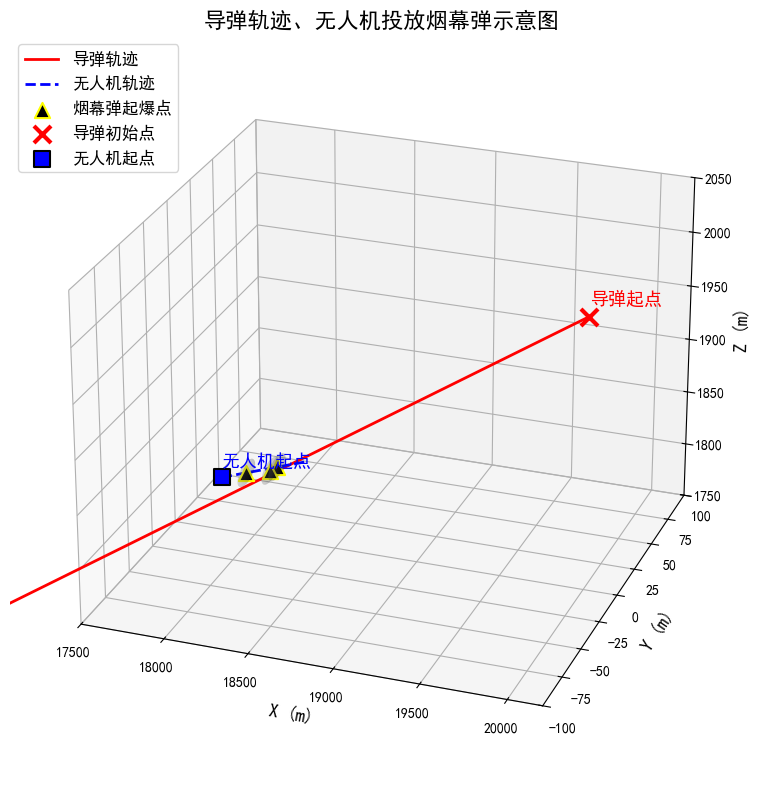

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体
plt.rcParams['axes.unicode_minus'] = False   # 正确显示负号

# --- 1. 定义常量 (与原始一致) ---
V_M1 = 300  # 导弹速度 (m/s)
P0_M1 = np.array([20000, 0, 2000])  # 导弹初始位置
TARGET_FALSE = np.array([0, 0, 0])   # 假目标位置

P0_FY1 = np.array([17800, 0, 1800]) # 无人机初始位置

# 真目标 (圆柱体)
TARGET_TRUE_CENTER_BASE = np.array([0, 200, 0]) # 底面中心
TARGET_TRUE_RADIUS = 7    # 半径 (m)
TARGET_TRUE_HEIGHT = 10   # 高度 (m)

# 烟幕
SMOKE_CLOUD_RADIUS = 10   # 烟幕云半径 (m)
G = 9.8  # 重力加速度 (m/s^2)

# --- 2. 运动学模型 ---
direction_m1 = (TARGET_FALSE - P0_M1) / np.linalg.norm(TARGET_FALSE - P0_M1)
def missile_position(t):
    return P0_M1 + V_M1 * t * direction_m1

def uav_position(v_f, theta, t):
    vx = v_f * np.cos(theta)
    vy = v_f * np.sin(theta)
    return P0_FY1 + t * np.array([vx, vy, 0])

def grenade_position(v_f, theta, t_d, t):
    if t < t_d: return uav_position(v_f, theta, t)
    p0_grenade = uav_position(v_f, theta, t_d)
    v0_grenade = np.array([v_f * np.cos(theta), v_f * np.sin(theta), 0])
    dt = t - t_d
    pos = p0_grenade + v0_grenade * dt + 0.5 * np.array([0, 0, -G]) * dt**2
    return pos

# --- 3. 示例参数（可根据实际最优解替换） ---
v_f = 70.0
theta = np.deg2rad(3.97)
t_d1, t_b1 = 1.5, 1.6
t_d2, t_b2 = 2.5, 3.16
t_d3, t_b3 = 3.5, 3.6

# --- 4. 计算轨迹点 ---
t_missile = np.linspace(0, 70, 300)
missile_traj = np.array([missile_position(t) for t in t_missile])

t_uav = np.linspace(0, t_d3+2, 100)
uav_traj = np.array([uav_position(v_f, theta, t) for t in t_uav])

drop_points = [
    uav_position(v_f, theta, t_d1),
    uav_position(v_f, theta, t_d2),
    uav_position(v_f, theta, t_d3)
]
detonation_points = [
    grenade_position(v_f, theta, t_d1, t_b1),
    grenade_position(v_f, theta, t_d2, t_b2),
    grenade_position(v_f, theta, t_d3, t_b3)
]

# --- 5. 绘制烟幕云球体 ---
def plot_sphere(ax, center, radius, color='gray', alpha=0.3):
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color=color, alpha=alpha, linewidth=0)

# --- 6. 绘图 ---
fig = plt.figure(figsize=(10, 8))  # 调整比例，更协调
ax = fig.add_subplot(111, projection='3d')

# 画导弹轨迹
ax.plot(missile_traj[:,0], missile_traj[:,1], missile_traj[:,2], 'r-', label='导弹轨迹', linewidth=2, zorder=1)

# 画无人机轨迹
ax.plot(uav_traj[:,0], uav_traj[:,1], uav_traj[:,2], 'b--', label='无人机轨迹', linewidth=2, zorder=2)

# 不显示烟幕弹投放点

# 画烟幕弹起爆点和烟幕云
for i, pt in enumerate(detonation_points):
    ax.scatter(pt[0], pt[1], pt[2], c='k', marker='^', s=120, label='烟幕弹起爆点' if i==0 else None, edgecolors='yellow', linewidths=1.5, zorder=6)
    #ax.text(pt[0], pt[1], pt[2]+10, f'起爆{i+1}', color='k', fontsize=13, weight='bold', zorder=10)
    plot_sphere(ax, pt, SMOKE_CLOUD_RADIUS, color='gray', alpha=0.15)

# 画导弹初始点
ax.scatter(P0_M1[0], P0_M1[1], P0_M1[2], c='r', marker='x', s=150, label='导弹初始点', linewidths=3, zorder=8)
ax.text(P0_M1[0], P0_M1[1], P0_M1[2]+10, '导弹起点', color='r', fontsize=13, weight='bold', zorder=10)

# 画无人机初始点
ax.scatter(P0_FY1[0], P0_FY1[1], P0_FY1[2], c='b', marker='s', s=120, label='无人机起点', edgecolors='black', linewidths=1.5, zorder=9)
ax.text(P0_FY1[0], P0_FY1[1], P0_FY1[2]+10, '无人机起点', color='b', fontsize=13, weight='bold', zorder=10)

# ================== 修正坐标系显示 ==================
# 只显示导弹、无人机、烟幕弹等相关区域，去除假目标和真目标所在的区域
# 这里我们人为设置一个合适的显示范围，避开原点和真目标区域
# 例如：X轴从17500到20200，Y轴从-100到100，Z轴从1750到2050

ax.set_xlim(17500, 20200)
ax.set_ylim(-100, 100)
ax.set_zlim(1750, 2050)

ax.set_xlabel('X (m)', fontsize=13)
ax.set_ylabel('Y (m)', fontsize=13)
ax.set_zlabel('Z (m)', fontsize=13)
ax.set_title('导弹轨迹、无人机投放烟幕弹示意图', fontsize=16, weight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.view_init(elev=25, azim=-70)
plt.tight_layout()
plt.show()